Стемминг

In [ ]:
#stemmer = SnowballStemmer(language='russian')
#tokenizer = nltk.tokenize.WhitespaceTokenizer()

#def stemming(text):
#    tokens = [stemmer.stem(w) for w in tokenizer.tokenize(text)]
#    return " ".join(tokens)

In [ ]:
#df.text = [stemming(i) for i in df.text]

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [ ]:
df = pd.read_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset.csv")
df = df.dropna(axis = 0)
df.shape

(28015, 2)

In [ ]:
df

,category,text
0,Благоустройство территории,На трассе Нижнекамск-Чистополь в лесополосе у ...
1,Благоустройство территории,Во дворе дома Ленинградская 29 отсутствуют пар...
2,Содержание и ремонт муниципальных дорог,Добрый день! Не осуществляется уборка снега в ...
3,Благоустройство территории,Добрый день! Не осуществляется вывоз мусора с ...
4,Содержание и ремонт муниципальных дорог,на данном участке проезжей части от ул.Халитов...
...,...,...
29013,Благоустройство территории,Не производится уборка на детской площадке дом...
29014,Cвалки,"Свалка отходов, мусора в гаражном кооперативе ..."
29015,Cвалки,Огромная свалка
29016,Благоустройство территории,"Здравствуйте. Каждый год одно и тоже, с тех по..."


In [ ]:
df.category = df.category.replace(df.category.value_counts()[df.category.value_counts() < 25].index, 'Разное')

In [ ]:
df.category.value_counts()

Благоустройство территории                                 12967
Содержание и ремонт муниципальных дорог                     6948
Нарушение в наружной рекламе                                2079
Организация дорожного движения                              2040
Общественный транспорт                                       936
Бездомные животные                                           726
Поликлиники и больницы                                       524
Парки и скверы                                               406
Cвалки                                                       335
Мобильная связь                                              200
Воздух                                                       142
Капитальный ремонт                                           127
Детские сады                                                 126
Разное                                                       119
Санитарное состояние                                          91
Доступная среда          

## Подключение важных библиотек и загрузка языковой модели

In [ ]:
#from textblob import TextBlob
#from spacy.lang.ru import Russian
#nlp = Russian()
#import nltk
#from nltk.stem.snowball import SnowballStemmer
import spacy

In [ ]:
sp = spacy.load('ru_core_news_md')
all_stopwords = sp.Defaults.stop_words

## Предварительная обработка данных

Удаление стоп-слов

In [ ]:
def remove_mystopwords(sentence, stopwords):
    tokens = sentence.split(" ")
    tokens_filtered = [word for word in tokens if not word in stopwords]
    return (" ").join(tokens_filtered)

In [ ]:
%%time
df.text = [remove_mystopwords(i, all_stopwords) for i in df.text]

Wall time: 165 ms


Удаление пунктуации & Лематизация

In [ ]:
def f_lemma(text):
    tokens = sp(text)
    tokens = [token for token in tokens if not token.is_punct]
    tokens = [t.lemma_ for t in tokens]
    return " ".join(tokens)

In [ ]:
%%time
df.text = [f_lemma(i) for i in df.text]

Wall time: 6min 53s


In [ ]:
df.to_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset_preProcess.csv", index=False)

## Тематическое моделирование

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
from wordcloud import WordCloud

In [ ]:
df = pd.read_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset_preProcess.csv")

In [ ]:
NUM_TOPICS = 10

In [ ]:
vectorizer = TfidfVectorizer()
data_vectorized = vectorizer.fit_transform(df["text"])

In [ ]:
vectorizer = CountVectorizer(min_df=5, max_df=0.9)
data_vectorized = vectorizer.fit_transform(df["text"])

In [ ]:
%%time
# Latent Dirichlet Allocation Model
lda = LatentDirichletAllocation(n_components=NUM_TOPICS, max_iter=10, learning_method='online',verbose=True)
data_lda = lda.fit_transform(data_vectorized)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
Wall time: 1min 1s


In [ ]:
%%time
# NMF Model
lda = NMF(n_components=NUM_TOPICS, max_iter=10, verbose=True)
data_lda = lda.fit_transform(data_vectorized)

violation: 1.0
violation: 0.2811427675285106
violation: 0.11001612459229773
violation: 0.046640569017291356
violation: 0.028450225708948174
violation: 0.019211761259161415
violation: 0.013751756665204975
violation: 0.009916826537913688
violation: 0.007270665992554396
violation: 0.005390247263815264
Wall time: 666 ms


In [ ]:
%%time
# TruncatedSVD Model
lda = TruncatedSVD(n_components=NUM_TOPICS)
data_lda = lda.fit_transform(data_vectorized)

Wall time: 331 ms


In [ ]:
df_lda = pd.DataFrame(data_lda, columns=['topic_' + str(i) for i in range(0, NUM_TOPICS)])

In [ ]:
df_lda

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,0.269110,0.018465,0.018465,0.065403,0.018465,0.018465,0.536229,0.018465,0.018465,0.018465
1,0.016085,0.207965,0.016085,0.016085,0.016085,0.016085,0.663354,0.016085,0.016085,0.016085
2,0.020026,0.020027,0.213965,0.020026,0.020026,0.020026,0.625823,0.020026,0.020027,0.020026
3,0.020405,0.020405,0.020405,0.020405,0.020405,0.020405,0.816354,0.020405,0.020405,0.020405
4,0.020224,0.020224,0.020224,0.020224,0.261602,0.020224,0.576604,0.020224,0.020224,0.020224
...,...,...,...,...,...,...,...,...,...,...
28010,0.020800,0.020800,0.020800,0.020800,0.020800,0.086946,0.746656,0.020800,0.020800,0.020800
28011,0.020563,0.020563,0.020563,0.020563,0.020563,0.093369,0.693030,0.020563,0.069661,0.020563
28012,0.041425,0.041425,0.041425,0.041425,0.041425,0.041425,0.627172,0.041425,0.041425,0.041425
28013,0.017053,0.017053,0.017053,0.017053,0.017053,0.017053,0.846526,0.017053,0.017053,0.017053


In [ ]:
vocab = vectorizer.get_feature_names()

In [ ]:
# Generate a word cloud image for given topic
def draw_word_cloud(index):
    imp_words_topic=""
    comp=lda.components_[index]
    vocab_comp = zip(vocab, comp)
    sorted_words = sorted(vocab_comp, key= lambda x:x[1], reverse=True)[:50]
    for word in sorted_words:
        imp_words_topic=imp_words_topic+" "+word[0]
    wordcloud = WordCloud(width=1600, height=1400).generate(imp_words_topic)
    plt.figure( figsize=(5,5))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

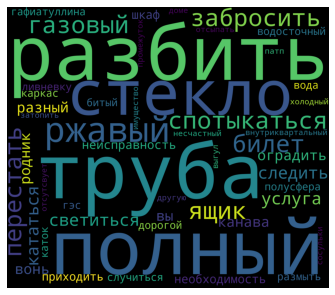

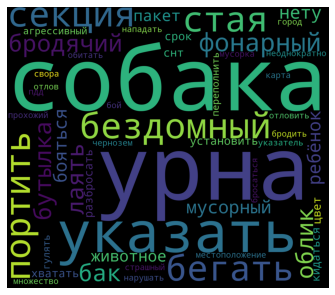

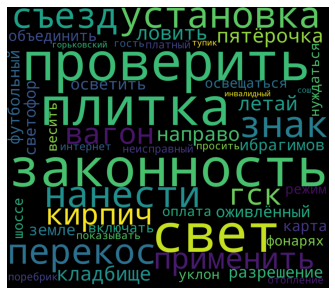

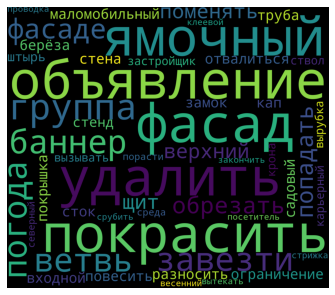

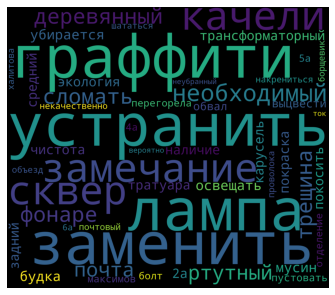

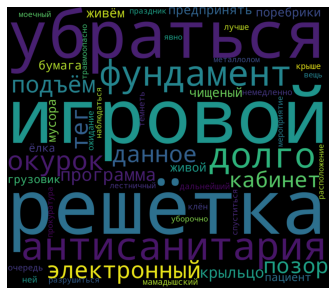

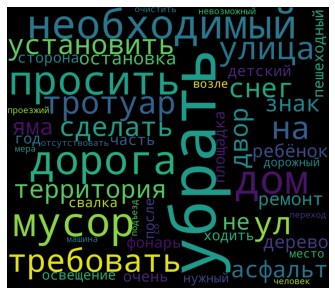

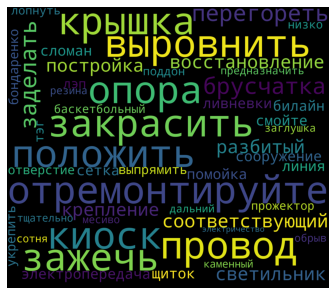

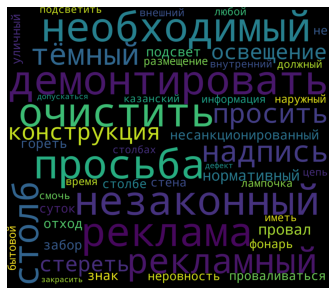

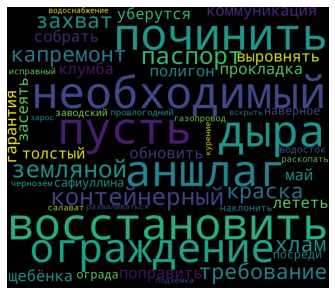

In [ ]:
for i in range(0, NUM_TOPICS):
    draw_word_cloud(i)

In [ ]:
def selected_topics(model, vectorizer, top_n=5):
    for idx, topic in enumerate(model.components_):
        print("Topic %d:" % (idx))
        print([(vectorizer.get_feature_names()[i], topic[i])
                        for i in topic.argsort()[:-top_n - 1:-1]]) 

In [ ]:
print("LDA Model:")
selected_topics(lda, vectorizer)

LDA Model:
Topic 0:
[('демонтировать', 803.6879450917285), ('просьба', 498.43663599916954), ('реклама', 454.64916268804535), ('просить', 272.3042266743251), ('дерево', 225.43639455494585)]
Topic 1:
[('фасад', 63.44842336058761), ('проверить', 36.412248303024796), ('законность', 33.01378558082769), ('дыра', 29.059940404615368), ('размещение', 27.734363656314645)]
Topic 2:
[('фонарь', 177.84654981199367), ('освещение', 157.7445126661595), ('столб', 140.93853022440197), ('гореть', 117.29303502440366), ('устранить', 112.27600338414625)]
Topic 3:
[('удалить', 120.31331858969938), ('надпись', 97.45152011598655), ('стереть', 55.54601197013225), ('урна', 46.245122207246744), ('портить', 43.07963926864229)]
Topic 4:
[('очистить', 210.96227276458688), ('необходимый', 116.91063346882599), ('выровнить', 38.286633993684944), ('тротуар', 26.838014402014714), ('карта', 22.955749140157955)]
Topic 5:
[('опора', 121.57669264259016), ('восстановить', 106.50904775278346), ('качели', 40.850594712698474), (

## Поиск ключевых слов

In [ ]:
# Keyword Extraction

## Анализ тональности 

In [ ]:
from dostoevsky.tokenization import RegexTokenizer
from dostoevsky.models import FastTextSocialNetworkModel

In [ ]:
%%time
tokenizer = RegexTokenizer()
model = FastTextSocialNetworkModel(tokenizer = tokenizer)

messages = df.text

results = model.predict(messages, k = 5)

Wall time: 6.72 s


In [ ]:
dostoevsky_result = pd.DataFrame(results)
dostoevsky_result.head()

,neutral,negative,skip,positive,speech
0,0.562187,0.437833,0.115971,0.035155,0.001937
1,0.771854,0.341593,0.067557,0.040856,0.002126
2,0.651365,0.152042,0.069552,0.106701,0.002991
3,0.585111,0.245095,0.095359,0.044691,0.019729
4,0.817585,0.156115,0.061886,0.037337,0.002642


In [ ]:
for message, sentiment in zip(messages[0:5], results[0:5]):
    print(message)
    print(sentiment, '\n')

на трасса нижнекамск чистополь лесополоса пгт камский поляна над проезжий часть опасно нависать накренившиеся дерево при снегопад выдержать рухнуть проходить автотранспорт
{'neutral': 0.5621865391731262, 'negative': 0.4378334879875183, 'skip': 0.11597072333097458, 'positive': 0.03515484184026718, 'speech': 0.0019367348868399858} 

во двор дом ленинградский 29 отсутствовать парковочный место житель дом постоянно мучиться проезд двор неоднократно происходить дтп со сторона ленинградской запретить оставлять машина согласно установить знак 3.28 предложение расширение место авто фото
{'neutral': 0.771853506565094, 'negative': 0.3415925204753876, 'skip': 0.06755668669939041, 'positive': 0.040855713188648224, 'speech': 0.0021257030311971903} 

добрый день не осуществляться уборка снег центр город гость житель воспользоваться платный парковка движение автотранспорт крайне затруднить
{'neutral': 0.6513648629188538, 'negative': 0.1520422399044037, 'positive': 0.1067005917429924, 'skip': 0.069551

## Векторизация текста

In [ ]:
df = pd.read_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset_preProcess.csv")

In [ ]:
%%time
l = []
for i in df.text:
    l.append(sp(i).vector)
l = np.array(l)

Wall time: 6min 14s


In [ ]:
d = pd.DataFrame(l, columns=['vec_' + str(i) for i in range(0, 300)])

In [ ]:
d.to_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset_vec_300.csv", index=False)

In [ ]:
d = pd.read_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset_vec_300.csv")
df = pd.read_csv("C:/Disk_for_Data_Science/MazalTovGeksli/Projects/Text/dataset.csv")
df = df.dropna(axis = 0)
df.shape

(28015, 2)

In [ ]:
d.head()

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_290,vec_291,vec_292,vec_293,vec_294,vec_295,vec_296,vec_297,vec_298,vec_299
0,0.048958,-0.100826,0.151323,-0.114938,0.157246,-0.067575,-0.047382,-0.019138,0.048183,0.026951,...,0.127107,0.018464,0.139469,0.124484,-0.032045,0.086036,-0.182581,-0.019185,-0.041339,-0.047872
1,0.095776,-0.188145,0.050359,-0.066947,0.068280,-0.055808,0.031464,-0.032428,0.051900,0.115358,...,-0.017223,0.013099,0.061617,0.072654,0.136350,0.013697,-0.145991,-0.052428,0.008410,0.005035
2,0.107438,-0.101761,0.150548,0.063252,0.025374,-0.063707,0.056086,0.121381,0.116058,0.061284,...,-0.043956,0.076187,0.018016,0.126044,0.204220,0.070061,-0.032844,-0.181819,-0.016433,0.066000
3,-0.067309,-0.055831,0.005297,0.012447,0.027207,-0.048412,0.076848,0.060090,-0.075491,0.045202,...,-0.027473,-0.061889,-0.058118,0.155419,0.036334,-0.050897,-0.161441,-0.265364,-0.096643,-0.015059
4,0.038655,-0.103342,0.118558,0.027153,0.109586,0.091247,0.009278,0.075964,-0.015192,0.018848,...,-0.002732,-0.016289,0.002126,0.125495,0.108831,0.035809,-0.015601,-0.052610,0.092506,0.153826


In [ ]:
from sklearn.manifold import TSNE
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
pipe = make_pipeline(StandardScaler(), TSNE(n_components = 2))
X = d
y = df.category

In [ ]:
X.shape

(28015, 300)

In [ ]:
y = y.replace(y.value_counts()[y.value_counts() < 25].index, 'Rare Title')

In [ ]:
%%time
X_tsne = pipe.fit_transform(X)

Wall time: 2min 33s


In [ ]:
X_tsne = pd.DataFrame(X_tsne)
X_tsne.rename(columns = {0:'1-я компонента', 1:'2-я компонента'}, inplace = True)
X_tsne["Class"] = y

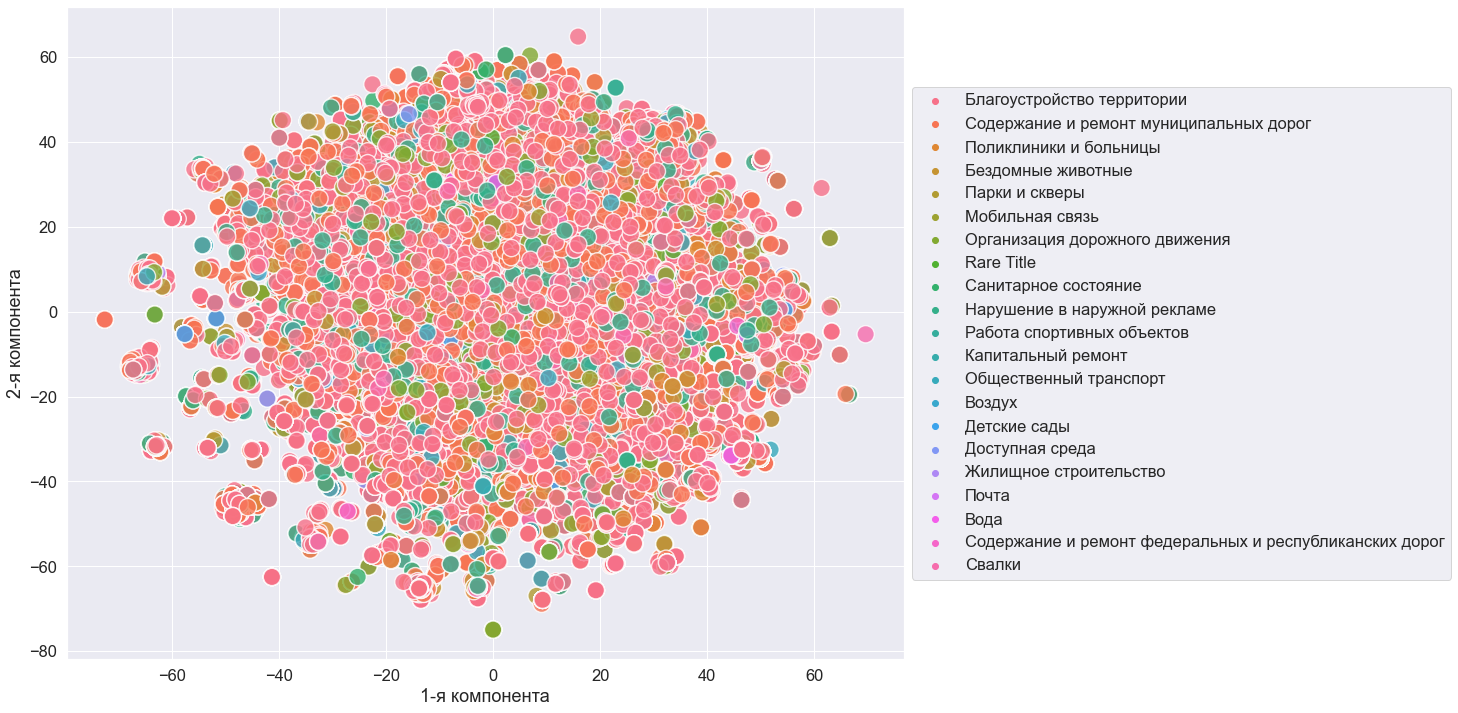

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 12))
g = sns.scatterplot(x = "1-я компонента", y = "2-я компонента", hue = "Class", data = X_tsne, s = 300, alpha = 0.8)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)

## Кластеризация

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score

Wall time: 720 ms


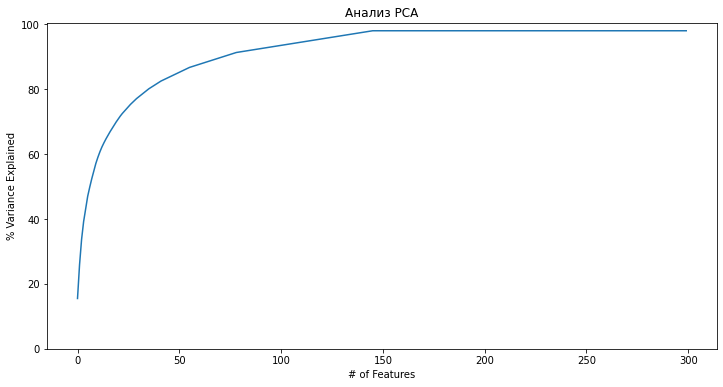

In [ ]:
%%time
pca = PCA(n_components = 300) 
pca.fit(d)

variance = pca.explained_variance_ratio_
var = np.cumsum (np.round (variance, 3) * 100) 
plt.figure(figsize = (12,6)) 
plt.ylabel('% Variance Explained') 
plt.xlabel('# of Features') 
plt .title('Анализ PCA') 
plt.ylim(0, 100.5)
plt.plot(var)

In [ ]:
mms = MinMaxScaler()
mms.fit(d)
d_clus = mms.transform(d)

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
%%time
kmeans = KMeans(n_clusters = 3, n_init = 100, max_iter = 400, init = 'k-means++').fit(d_clus)

Wall time: 20.5 s


In [ ]:
X_tsne["Kmeans3"] = kmeans.labels_
X_tsne["Kmeans3"] = X_tsne["Kmeans3"].astype("string")

In [ ]:
print('KMeans Scaled Silhouette Score: {}'.format(silhouette_score(d_clus, kmeans.labels_, metric = 'euclidean')))

KMeans Scaled Silhouette Score: 0.28744311362158775


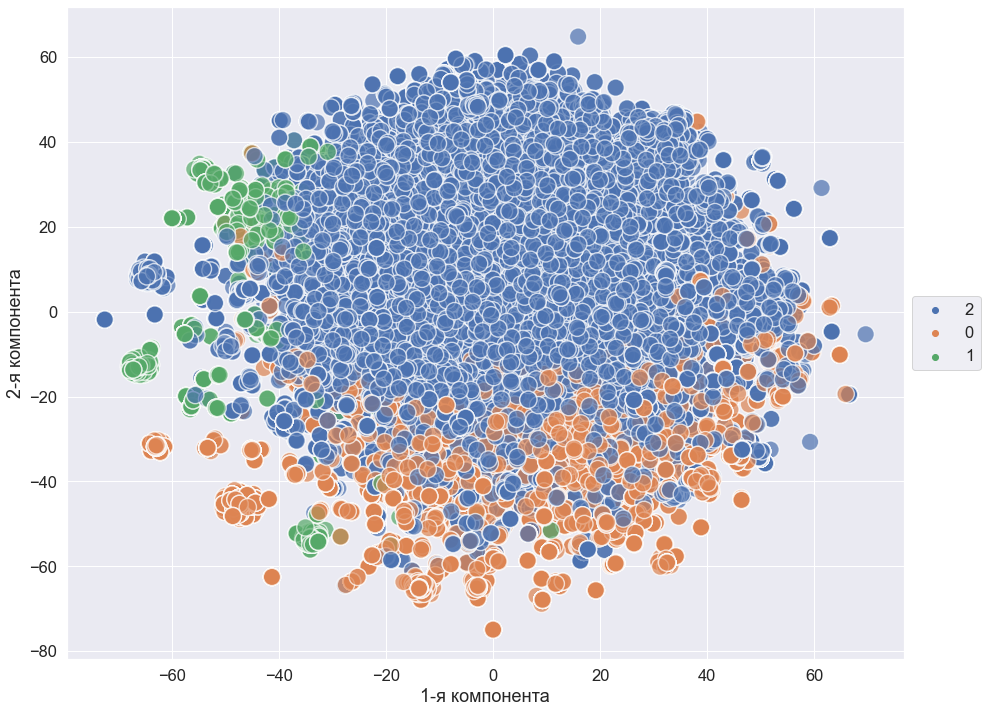

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 12))
g = sns.scatterplot(x = "1-я компонента", y = "2-я компонента", hue = "Kmeans3", data = X_tsne, s = 300, alpha = 0.7)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)

In [ ]:
from sklearn.cluster import AgglomerativeClustering

In [ ]:
%%time
clustering = AgglomerativeClustering(n_clusters = 4).fit(d_clus)

Wall time: 2min 55s


In [ ]:
X_tsne["Agglomerative"] = clustering.labels_
X_tsne["Agglomerative"] = X_tsne["Agglomerative"].astype("string")

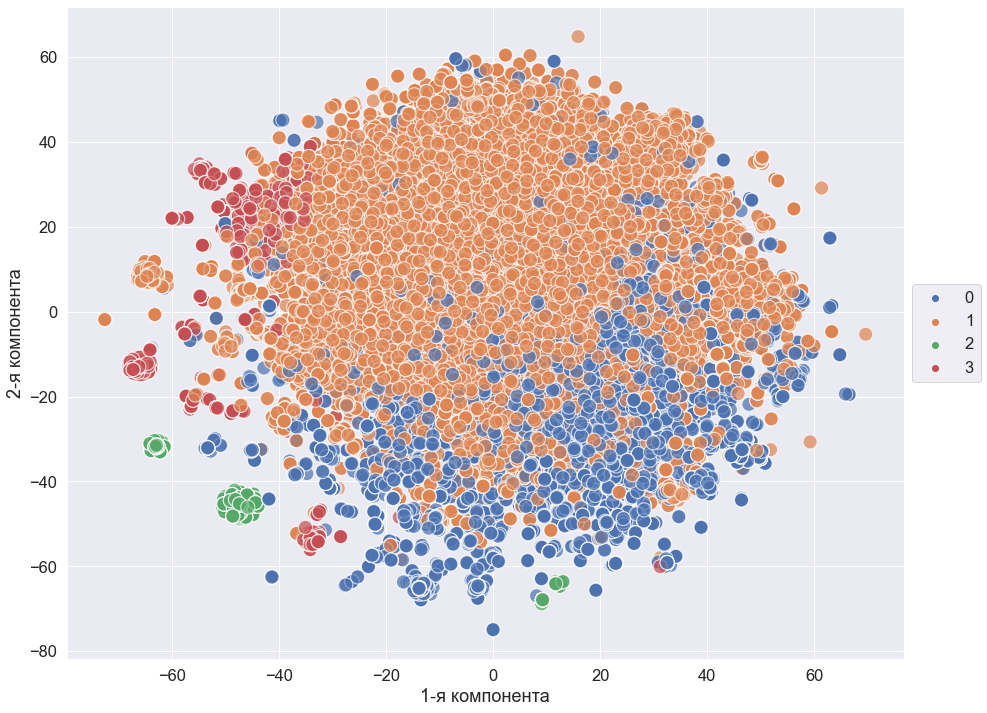

In [ ]:
sns.set(font_scale = 1.5)
f, ax = plt.subplots(figsize=(15, 12))
g = sns.scatterplot(x = "1-я компонента", y = "2-я компонента", hue = "Agglomerative", data = X_tsne, s = 200, alpha = 0.7)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol = 1)

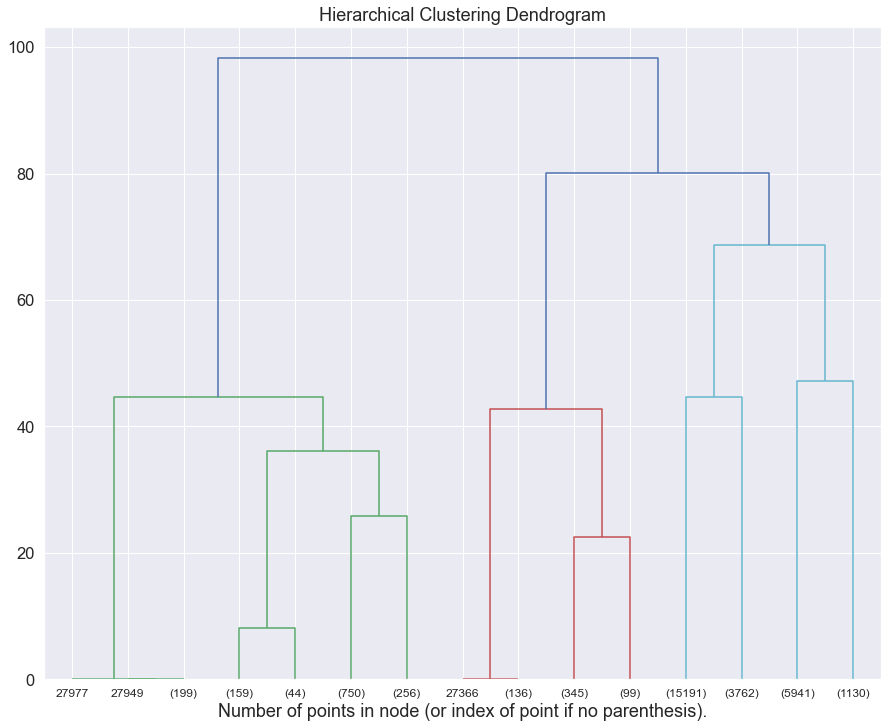

In [ ]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

clustering = AgglomerativeClustering(n_clusters = None, distance_threshold = 0).fit(d_clus)

f, ax = plt.subplots(figsize=(15, 12))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(clustering, truncate_mode='level', p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

## Создание дополнительных признаков

In [ ]:
X = pd.concat([df_lda, d, dostoevsky_result], axis=1)

Wall time: 720 ms


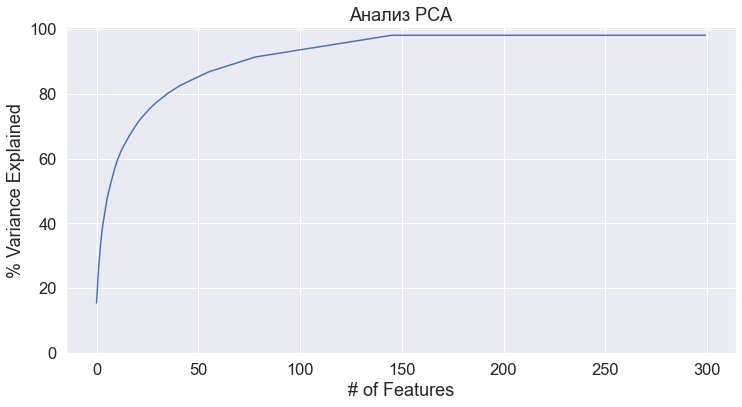

In [ ]:
%%time
pca = PCA(n_components = 300) 
pca.fit(d)

variance = pca.explained_variance_ratio_
var = np.cumsum (np.round (variance, 3) * 100) 
plt.figure(figsize = (12,6)) 
plt.ylabel('% Variance Explained') 
plt.xlabel('# of Features') 
plt .title('Анализ PCA') 
plt.ylim(0, 100.5)
plt.plot(var)

In [ ]:
pca = PCA(n_components = 150) 

In [ ]:
X = pca.fit_transform(X)

In [ ]:
X = pd.DataFrame(X)
X

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-0.567341,-0.297261,-0.743944,-0.292743,-0.160349,-0.003337,0.093310,-0.267412,0.211641,0.057404,...,0.004123,0.027705,0.000811,0.003225,0.059143,-0.013599,-0.006064,-0.032431,-0.023288,-0.071981
1,0.105652,-0.486980,0.110122,-0.085403,-0.096004,0.136446,0.147222,0.266628,-0.022268,0.004239,...,-0.016090,-0.048614,0.002979,-0.035100,-0.001582,-0.030855,0.060103,-0.012784,0.014676,-0.015250
2,-0.161489,-0.441557,0.168642,0.019212,0.059139,0.074036,0.106524,0.275902,-0.325908,-0.046429,...,-0.000642,0.012741,0.006489,0.062316,-0.004427,0.010595,0.013556,0.002753,0.048979,0.102095
3,0.527360,-0.333926,0.259139,-0.219865,0.350973,-0.291248,-0.104958,0.129246,-0.070167,-0.051219,...,0.033315,0.020188,0.019290,-0.018312,0.030836,0.017082,0.033241,-0.074199,0.033795,-0.004933
4,-0.314868,-0.401072,0.102420,0.120917,0.222221,-0.316660,0.012771,0.103543,-0.225649,-0.239912,...,0.002203,0.002998,0.031092,-0.006960,0.055779,-0.004604,0.044626,0.067769,0.076483,0.076643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28010,0.087169,-0.133604,-0.416285,-0.289518,-0.289340,0.220222,0.055719,0.002619,0.130666,0.082835,...,0.070178,-0.029232,-0.041762,-0.014935,0.026461,0.013231,0.002151,0.011121,-0.050002,0.049413
28011,0.013409,-0.133160,-0.703007,-0.311403,-0.034475,0.234832,0.138611,0.266137,-0.100369,0.314901,...,0.026880,-0.047607,0.055192,-0.017034,0.017192,-0.019459,0.045737,-0.032687,0.040700,-0.011844
28012,-0.045872,0.116902,-0.284421,-0.129736,-0.837787,-0.355043,-0.355923,-0.270699,0.358989,-0.152719,...,0.069561,0.001699,0.148235,0.014065,-0.056943,0.028154,-0.049080,-0.057667,0.054607,0.026278
28013,0.892553,-0.259991,0.304432,0.232681,-0.182240,-0.291770,0.138829,0.056024,-0.014408,0.023676,...,0.004182,0.005455,-0.011610,-0.018493,-0.010240,-0.015606,0.010661,0.028351,0.025757,0.011422


## Классификация

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, stratify = y)
X_train = X_train.reset_index(drop = True)
y_train = y_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)
y_test = y_test.reset_index(drop = True)

In [ ]:
%%time
scaler = StandardScaler()
col = X_train.columns
X_train = scaler.fit_transform(X_train) 
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns = col) 
X_test = pd.DataFrame(X_test, columns = col)

Wall time: 125 ms


In [ ]:
%%time
model_SVC = SVC(C = 1, kernel = 'linear')
model_SVC.fit(X_train, y_train)
pred_svm = model_SVC.predict(X_test)

Wall time: 6min 6s


In [ ]:
fuyfkjgkjlhlkhlkj

In [ ]:
fkgkgkh

In [ ]:
f1_score_svm = f1_score(y_test, pred_svm, average='macro')
f1_score_svm

0.6035735389147661

In [ ]:
f1_score_svm = f1_score(y_test, pred_svm, average='macro')
f1_score_svm

0.41813620904156157

In [ ]:
from catboost import Pool, CatBoostClassifier

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10)
val_pool = Pool(X_val, y_val)

In [ ]:
model_CatB = CatBoostClassifier(verbose = True, 
                                iterations =500, 
                                loss_function = 'MultiClass', 
                                use_best_model = True, 
                                early_stopping_rounds = 50)

In [ ]:
model_CatB.fit(X_train, y_train, eval_set = val_pool)
pred_CatB = model_CatB.predict(X_test)

Learning rate set to 0.149108
0:	learn: 2.2970559	test: 2.3178466	best: 2.3178466 (0)	total: 1.84s	remaining: 15m 17s
1:	learn: 2.0427781	test: 2.0733580	best: 2.0733580 (1)	total: 3.66s	remaining: 15m 11s
2:	learn: 1.8687708	test: 1.8938963	best: 1.8938963 (2)	total: 5.49s	remaining: 15m 9s
3:	learn: 1.7532369	test: 1.7816154	best: 1.7816154 (3)	total: 7.31s	remaining: 15m 6s
4:	learn: 1.6558992	test: 1.6859440	best: 1.6859440 (4)	total: 9.13s	remaining: 15m 3s
5:	learn: 1.5852355	test: 1.6167469	best: 1.6167469 (5)	total: 11.1s	remaining: 15m 10s
6:	learn: 1.5197337	test: 1.5532194	best: 1.5532194 (6)	total: 12.9s	remaining: 15m 7s
7:	learn: 1.4644291	test: 1.4993052	best: 1.4993052 (7)	total: 14.7s	remaining: 15m 5s
8:	learn: 1.4177083	test: 1.4555867	best: 1.4555867 (8)	total: 16.5s	remaining: 15m 2s
9:	learn: 1.3851248	test: 1.4275089	best: 1.4275089 (9)	total: 18.4s	remaining: 15m 1s
10:	learn: 1.3497160	test: 1.3950358	best: 1.3950358 (10)	total: 20.2s	remaining: 14m 58s
11:	lea

91:	learn: 0.7263509	test: 0.9286406	best: 0.9286406 (91)	total: 2m 49s	remaining: 12m 30s
92:	learn: 0.7222020	test: 0.9268467	best: 0.9268467 (92)	total: 2m 51s	remaining: 12m 29s
93:	learn: 0.7179250	test: 0.9245678	best: 0.9245678 (93)	total: 2m 53s	remaining: 12m 27s
94:	learn: 0.7147197	test: 0.9233382	best: 0.9233382 (94)	total: 2m 54s	remaining: 12m 25s
95:	learn: 0.7115309	test: 0.9218253	best: 0.9218253 (95)	total: 2m 56s	remaining: 12m 23s
96:	learn: 0.7089618	test: 0.9198485	best: 0.9198485 (96)	total: 2m 58s	remaining: 12m 21s
97:	learn: 0.7052392	test: 0.9179926	best: 0.9179926 (97)	total: 3m	remaining: 12m 19s
98:	learn: 0.7015069	test: 0.9165085	best: 0.9165085 (98)	total: 3m 2s	remaining: 12m 17s
99:	learn: 0.6988888	test: 0.9152903	best: 0.9152903 (99)	total: 3m 4s	remaining: 12m 16s
100:	learn: 0.6969260	test: 0.9145930	best: 0.9145930 (100)	total: 3m 5s	remaining: 12m 14s
101:	learn: 0.6932368	test: 0.9125652	best: 0.9125652 (101)	total: 3m 7s	remaining: 12m 12s
102

180:	learn: 0.5240669	test: 0.8459517	best: 0.8459517 (180)	total: 5m 32s	remaining: 9m 45s
181:	learn: 0.5227698	test: 0.8457787	best: 0.8457787 (181)	total: 5m 33s	remaining: 9m 43s
182:	learn: 0.5211031	test: 0.8455021	best: 0.8455021 (182)	total: 5m 35s	remaining: 9m 41s
183:	learn: 0.5197408	test: 0.8451021	best: 0.8451021 (183)	total: 5m 37s	remaining: 9m 39s
184:	learn: 0.5184135	test: 0.8444342	best: 0.8444342 (184)	total: 5m 39s	remaining: 9m 37s
185:	learn: 0.5171102	test: 0.8441027	best: 0.8441027 (185)	total: 5m 41s	remaining: 9m 35s
186:	learn: 0.5155120	test: 0.8437557	best: 0.8437557 (186)	total: 5m 42s	remaining: 9m 34s
187:	learn: 0.5144016	test: 0.8434134	best: 0.8434134 (187)	total: 5m 44s	remaining: 9m 32s
188:	learn: 0.5130075	test: 0.8429132	best: 0.8429132 (188)	total: 5m 46s	remaining: 9m 30s
189:	learn: 0.5114699	test: 0.8425495	best: 0.8425495 (189)	total: 5m 48s	remaining: 9m 28s
190:	learn: 0.5094672	test: 0.8421610	best: 0.8421610 (190)	total: 5m 50s	remain

270:	learn: 0.4149645	test: 0.8183988	best: 0.8183988 (270)	total: 8m 16s	remaining: 6m 59s
271:	learn: 0.4135795	test: 0.8180888	best: 0.8180888 (271)	total: 8m 18s	remaining: 6m 58s
272:	learn: 0.4126469	test: 0.8184556	best: 0.8180888 (271)	total: 8m 20s	remaining: 6m 56s
273:	learn: 0.4116572	test: 0.8179910	best: 0.8179910 (273)	total: 8m 22s	remaining: 6m 54s
274:	learn: 0.4103219	test: 0.8175011	best: 0.8175011 (274)	total: 8m 24s	remaining: 6m 52s
275:	learn: 0.4094314	test: 0.8169523	best: 0.8169523 (275)	total: 8m 26s	remaining: 6m 50s
276:	learn: 0.4083902	test: 0.8171017	best: 0.8169523 (275)	total: 8m 27s	remaining: 6m 48s
277:	learn: 0.4078333	test: 0.8167798	best: 0.8167798 (277)	total: 8m 29s	remaining: 6m 47s
278:	learn: 0.4067672	test: 0.8166189	best: 0.8166189 (278)	total: 8m 31s	remaining: 6m 45s
279:	learn: 0.4061119	test: 0.8164281	best: 0.8164281 (279)	total: 8m 33s	remaining: 6m 43s
280:	learn: 0.4050531	test: 0.8159798	best: 0.8159798 (280)	total: 8m 35s	remain

360:	learn: 0.3472413	test: 0.8060756	best: 0.8060756 (360)	total: 11m 1s	remaining: 4m 14s
361:	learn: 0.3468065	test: 0.8060916	best: 0.8060756 (360)	total: 11m 3s	remaining: 4m 12s
362:	learn: 0.3460320	test: 0.8057334	best: 0.8057334 (362)	total: 11m 4s	remaining: 4m 10s
363:	learn: 0.3453646	test: 0.8057141	best: 0.8057141 (363)	total: 11m 6s	remaining: 4m 9s
364:	learn: 0.3447081	test: 0.8056267	best: 0.8056267 (364)	total: 11m 8s	remaining: 4m 7s
365:	learn: 0.3442100	test: 0.8058681	best: 0.8056267 (364)	total: 11m 10s	remaining: 4m 5s
366:	learn: 0.3435806	test: 0.8055696	best: 0.8055696 (366)	total: 11m 12s	remaining: 4m 3s
367:	learn: 0.3430089	test: 0.8054515	best: 0.8054515 (367)	total: 11m 14s	remaining: 4m 1s
368:	learn: 0.3425064	test: 0.8051481	best: 0.8051481 (368)	total: 11m 15s	remaining: 3m 59s
369:	learn: 0.3419923	test: 0.8052434	best: 0.8051481 (368)	total: 11m 17s	remaining: 3m 58s
370:	learn: 0.3415104	test: 0.8049865	best: 0.8049865 (370)	total: 11m 19s	remai

449:	learn: 0.3006854	test: 0.7962629	best: 0.7962629 (449)	total: 13m 43s	remaining: 1m 31s
450:	learn: 0.3001435	test: 0.7960378	best: 0.7960378 (450)	total: 13m 45s	remaining: 1m 29s
451:	learn: 0.2995320	test: 0.7960763	best: 0.7960378 (450)	total: 13m 47s	remaining: 1m 27s
452:	learn: 0.2994051	test: 0.7961620	best: 0.7960378 (450)	total: 13m 49s	remaining: 1m 26s
453:	learn: 0.2987895	test: 0.7962460	best: 0.7960378 (450)	total: 13m 51s	remaining: 1m 24s
454:	learn: 0.2983250	test: 0.7959739	best: 0.7959739 (454)	total: 13m 53s	remaining: 1m 22s
455:	learn: 0.2978788	test: 0.7958468	best: 0.7958468 (455)	total: 13m 54s	remaining: 1m 20s
456:	learn: 0.2973856	test: 0.7957127	best: 0.7957127 (456)	total: 13m 56s	remaining: 1m 18s
457:	learn: 0.2969260	test: 0.7954858	best: 0.7954858 (457)	total: 13m 58s	remaining: 1m 16s
458:	learn: 0.2961649	test: 0.7956047	best: 0.7954858 (457)	total: 14m	remaining: 1m 15s
459:	learn: 0.2958399	test: 0.7955484	best: 0.7954858 (457)	total: 14m 2s	

In [ ]:
f1_score_CatB = f1_score(y_test, pred_CatB, average='macro')
f1_score_CatB

0.36728211405886774